In [2]:
import datetime
import numpy as np
import sys
import os
import xarray as xr

sys.path.append(os.environ.get('srcdir'))
# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

%aimport features.compare_tide
from features.compare_tide import compare_tide

%aimport features.compare_atg
from features.compare_atg import compare_atg
%aimport features.grid_ttide
from features.grid_ttide import *

In [94]:
#load data at certain time range
file_path = os.path.join(os.environ.get('rawdir'),'waom10_v2.0_small','ocean_his_hourly_ta_00*.nc')
zeta = xr.open_mfdataset(file_path).zeta#.sel(ocean_time=slice('2007-1-15','2007-2-15'))

#load grid
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
grid = xr.open_dataset(file_path)

In [107]:
print('record length: %.1f days' %(zeta.ocean_time.shape[0]/24))

record length: 365.0 days


In [95]:
#define functions that calculate rmsd to atg
from scipy.spatial import KDTree
import ttide as tt
import scipy.io as sio
from features.log_progress import log_progress
from features.haversine import haversine

def compare_atg(roms_zeta_da,grid,
                atg_mat_path=os.path.join(os.environ.get('projdir'),'data','analysis','external','atg','ATG_ocean_height_2010_0908.mat'),
                stime=datetime.datetime(2007,1,1),constit_list = ['M2','O1'],
                station_list=np.arange(1,109),print_flag=True):

    print('stime = ',stime,' constits = ',constit_list,'stations = ',station_list)
    
    mat_content = sio.loadmat(atg_mat_path)
    atg_data = mat_content['atg']

    station_dict = {}

    for station in log_progress(station_list,name='stations'):

        station_dict[station] = {}

        atg_dict = read_atg(atg_data,station,constit_list)
        lat = atg_dict['lat']
        lon = atg_dict['lon']
        eta_rho,xi_rho,dist,tt_dict = station_ttide(roms_zeta_da,grid,lat,lon,stime,constit_list)

        station_dict[station]['atg'] = atg_dict
        station_dict[station]['tt'] = tt_dict
        station_dict[station]['dist'] = dist
        station_dict[station]['eta_rho'] = eta_rho
        station_dict[station]['xi_rho'] = xi_rho

    rmse_dict = calc_rmse(station_dict,constit_list)

    if print_flag == True:
        print_station_dict(station_dict,constit_list)
        print_rmse(rmse_dict,constit_list)

    return station_dict,rmse_dict


def read_atg(atg_data,site_id,constit_list):

    site_data = {}
    for key in ['site_id','name','lat','lon','amp','Gphase','reclen','delta_t','meas_type','ref']:
        site_data[key] =np.squeeze(atg_data[key][0,0][site_id-1])
    site_data['constit']=np.squeeze(atg_data['constit'][0,0][:])
    site_data['name'] = site_data['name'].strip()

    cm2m = 1.0/100.0
    for const in constit_list:

        atg_con_ind = list(site_data['constit']).index(const)
        site_data[const]=np.array([site_data['amp'][atg_con_ind]*cm2m, site_data['Gphase'][atg_con_ind]])

    return site_data

def station_ttide(zeta_da,grid,lat_t,lon_t,stime,constit_list):

    zeta_flat = zeta_da.stack(etaxi = ('eta_rho','xi_rho'))
    grid_flat = grid.stack(etaxi = ('eta_rho','xi_rho'))

    lat_s = grid_flat.lat_rho.values[grid_flat.mask_rho.values==True]
    lon_s = grid_flat.lon_rho.values[grid_flat.mask_rho.values==True]
    zeta_s = zeta_flat.values[:,grid_flat.mask_rho.values==True]
    etaxi_s = zeta_flat.etaxi.values[grid_flat.mask_rho.values==True]

    points = np.column_stack((lat_s,lon_s))
    tree = KDTree(points)

    target = np.column_stack((lat_t,lon_t))
    dist, ind = tree.query(target)
    
    lat_r = lat_s[ind]
    lon_r = lon_s[ind]
    dist = haversine(lon_t,lat_t,lon_r,lat_r)

    tmp={}
    tmp['roms_signal'] = zeta_s[:,ind].squeeze()
    
    eta_rho,xi_rho = np.fromstring(str(etaxi_s[ind])[2:-2], sep=', ',dtype=int)
    
    try:
        tmp['t_tide']=tt.t_tide(tmp['roms_signal'],dt=1,stime=stime,lat=lat_r,out_style=None)
        
        for const in constit_list:
            tide_con_ind = list(tmp['t_tide']['nameu']).index(str.encode(const+'  '))
            tmp[const]=tmp['t_tide']['tidecon'][tide_con_ind]
            
    except TypeError:
        for const in constit_list:
             tmp[const]=[np.nan,np.nan,np.nan,np.nan]

    return eta_rho,xi_rho,dist,tmp

def calc_rmse(station_dict,constit_list):

    d2r = np.pi/180
    
    const_rmse={}

    sum_complex_mse = 0
    
    sum_excluded = 0
    
    for constit in constit_list:

        tt_amp = []
        atg_amp = []

        tt_phi =[]
        atg_phi =[]

        tt_z = []
        atg_z = []

        for station,data in station_dict.items():

            if data['dist'] > 50000:              
                print('Excluded Station '+data['atg']['name']+', since dist to roms point > 50km')
                sum_excluded+=1
                
            elif np.isnan(data['tt'][constit][0]):    
                print('Excluded Station '+data['atg']['name']+', since roms ttide failed')
                sum_excluded+=1
                
            elif np.isnan(data['atg'][constit][0]):    
                print('Excluded Station '+data['atg']['name']+', since atg failed')
                sum_excluded+=1
                
            else:

                tt_amp.append(data['tt'][constit][0])
                atg_amp.append(data['atg'][constit][0])

                tt_phi.append(data['tt'][constit][2])
                atg_phi.append(data['atg'][constit][1])

                tt_z.append(data['tt'][constit][0] * np.exp(1j*data['tt'][constit][2]*d2r))
                atg_z.append(data['atg'][constit][0] * np.exp(1j*data['atg'][constit][1]*d2r))
                
        tt_amp = np.array(tt_amp)
        atg_amp=np.array(atg_amp)
        tt_phi = np.array(tt_phi)
        atg_phi = np.array(atg_phi)
        tt_z = np.array(tt_z)
        atg_z = np.array(atg_z)
        
        const_rmse[constit] = {}

        const_rmse[constit]['amp']= np.sqrt(np.mean((tt_amp - atg_amp) ** 2))
        
        phi_diff = np.abs(tt_phi-atg_phi)
        phi_diff[phi_diff>180]-=360
    
        const_rmse[constit]['phase'] = np.sqrt(np.mean(phi_diff ** 2))
        
        complex_mse = 0.5*np.mean(((tt_z-atg_z)*np.conjugate(tt_z-atg_z)).real)
        
        const_rmse[constit]['complex_amp']=np.sqrt(complex_mse)
        
        sum_complex_mse += complex_mse
        
        const_rmse[constit]['nb_excluded'] = sum_excluded

    const_rmse['combined_complex'] = np.sqrt(sum_complex_mse)
    
    return const_rmse
 
def print_station_dict(station_dict,constit_list):
    print("Station ID || Amp(amp_err)[m]:  atg   roms || phase(phase_err)[deg]:  atg   roms || Station Name; RecLen [days]; Nearest Neibour [km]")
    for constit in constit_list:
        print(constit)
        for station_id,data in station_dict.items():
            print(station_id,"|| %0.2f"%data['atg'][constit][0]," %0.2f(%0.2f) "%(data['tt'][constit][0],data['tt'][constit][1]),\
                  "|| %0.2f"%data['atg'][constit][1]," %0.2f(%0.2f) "%(data['tt'][constit][2],data['tt'][constit][3]),\
                  "|| ",data['atg']['name']," ",data['atg']['reclen'],' %0.2f' %data['dist'][0])

def print_rmse(rmse_dict,constit_list):

    for constit in constit_list:
        data = rmse_dict[constit]
        
        print(constit+' RMSD: amp = %.2f m    phase = %.2f deg   complex amp = %.2f m'%(data['amp'],data['phase'],data['complex_amp']))
        print('Number excluded records: ',rmse_dict[constit]['nb_excluded'])
        
    print('Combined complex RMSD: %.2f'%rmse_dict['combined_complex'])

In [96]:
# calculate rms
staions,rms = compare_atg(zeta,grid,stime=datetime.datetime(2007,1,15),constit_list=['M2','N2','K1','O1'],station_list=range(0,109))

stime =  2007-01-15 00:00:00  constits =  ['M2', 'N2', 'K1', 'O1'] stations =  range(0, 109)


VBox(children=(HTML(value=''), IntProgress(value=0, max=109)))

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:619: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kathy"), since dist to roms point > 50km
Excluded Station 65300- Macquarie Island, since dist to roms point > 50km
Excluded Station 20090- Heard Island, since dist to roms point > 50km
Excluded Station Beaver Lake, since dist to roms point > 50km
Excluded Station ROPEX C1, since dist to roms point > 50km
Excluded Station Rutford GL Tilt/Grav, since dist to roms point > 50km
Excluded Station Lokcroy, since roms ttide failed
Excluded Station Amery Ice Shelf TS05 (partially grounded), since dist to roms point > 50km
Excluded Station Evans Ice Stream GPS: EE2B, since dist to roms point > 50km
Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kathy"), since dist to roms point > 50km
Excluded Stati

86 || 0.14  0.22(0.00)  || 4.76  192.78(0.59)  ||  FRIS GPS FR03 (inf. from CATS2008a)   68.0  5284.80
87 || 0.23  0.28(0.00)  || 28.65  235.88(0.82)  ||  FRIS GPS FR04 (inf. from FR05)   39.0  9664.42
88 || 0.18  0.21(0.00)  || 56.07  246.37(0.98)  ||  FRIS GPS FR05   370.0  4490.02
89 || 0.12  0.16(0.00)  || 65.69  265.21(0.92)  ||  FRIS GPS FR06 (inf. from CATS2008a)   55.0  2430.53
90 || 0.04  0.07(0.00)  || 102.61  289.10(1.68)  ||  FRIS GPS FR07   214.0  11387.37
91 || nan  0.12(0.00)  || nan  239.59(1.00)  ||  FRIS GPS FR08  (inf. from CATS2008a)   18.0  8508.38
92 || 0.10  0.14(0.00)  || 4.97  199.10(0.83)  ||  FRIS GPS FR09   307.0  3503.10
93 || 0.03  0.06(0.00)  || 309.09  179.92(1.14)  ||  FRIS GPS FR10 (inf. mean of FR07 & FR09)   78.0  5572.68
94 || 0.14  0.12(0.00)  || 220.95  59.28(0.68)  ||  Larsen C GPS LAR1 (inference from LAR2)   50.0  2186.75
95 || 0.14  0.13(0.00)  || 228.26  54.59(0.67)  ||  Larsen C GPS LAR2   433.0  3317.87
96 || 0.14  0.12(0.00)  || 217.71  51

14 || 0.17  0.20(0.00)  || 53.00  56.11(0.14)  ||  PTC_4_2_21   320.0  414934.87
15 || 0.22  0.21(0.00)  || 51.00  54.58(0.14)  ||  PTC_4_2_24   320.0  3710.60
16 || 0.20  0.19(0.00)  || 49.00  48.62(0.19)  ||  PTC_4_2_27   378.0  1298.64
17 || 0.19  0.18(0.00)  || 55.00  54.08(0.14)  ||  PTC_4_2_30   377.0  5517.10
18 || 0.16  0.20(0.00)  || 52.00  58.41(0.17)  ||  PTC_4_2_32   364.0  515302.72
19 || 0.24  0.23(0.00)  || 54.00  53.95(0.07)  ||  PTC_4_2_33   358.0  2989.17
20 || 0.27  0.24(0.00)  || 343.00  341.42(0.13)  ||  PTC_4_2_34 (Sanae Base)   653.0  4377.64
21 || 0.12  0.13(0.00)  || 220.00  223.53(0.18)  ||  PTC_4_1_02 (Station "Kathy")   32.0  406940.29
22 || 0.15  0.16(0.00)  || 215.00  217.37(0.18)  ||  PTC_4_1_03  (Station "Flicki")   21.0  6483.94
23 || 0.25  0.22(0.00)  || 284.59  289.26(0.17)  ||  20080- Mawson   365.0  10212.16
24 || 0.29  0.25(0.00)  || 269.02  267.75(0.18)  ||  20100- Davis   365.0  3298.96
25 || 0.27  0.23(0.00)  || 233.66  237.55(0.17)  ||  20120- 

In [97]:
# complex rmsd on map

def plot_zdiff_map(stations_dict,grid,constit):

    deg2rad = np.pi/180
    xi = []
    eta = []
    diff = []
    sum_excl = 0

    
    for key,sta in staions.items():

        if sta['dist'] > 50000 or np.isnan(sta['tt'][constit][0]) or np.isnan(sta['atg'][constit][0]):
            sum_excl += 1

        else:
            xi.append(sta['xi_rho'])
            eta.append(sta['eta_rho'])
            tt_amp = sta['tt'][constit][0]
            tt_phase = sta['tt'][constit][2]*deg2rad
            atg_amp = sta['atg'][constit][0]
            atg_phase = sta['atg'][constit][1]*deg2rad

            atg_z = cmath.rect(atg_amp,atg_phase)
            tt_z = cmath.rect(tt_amp,tt_phase)

            diff.append(abs(atg_z-tt_z)/2*100)

    print("Excluded ",sum_excl,' stations')
    plt.close()
    fig,ax = plt.subplots(1,figsize=(15,10))
    plt.title(constit+' complex difference to ATG in cm \n colors scaled to mean+std',fontsize=24)
    ax.contour(grid.mask_rho.values,colors='k',alpha=0.1)
    scatter = ax.scatter(xi,eta,s=100,c=diff,edgecolors='k',alpha=0.9,vmin =0,vmax=np.mean(diff)+np.std(diff))
    plt.colorbar(scatter,ax=ax,extend="max")
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()

Excluded  11  stations


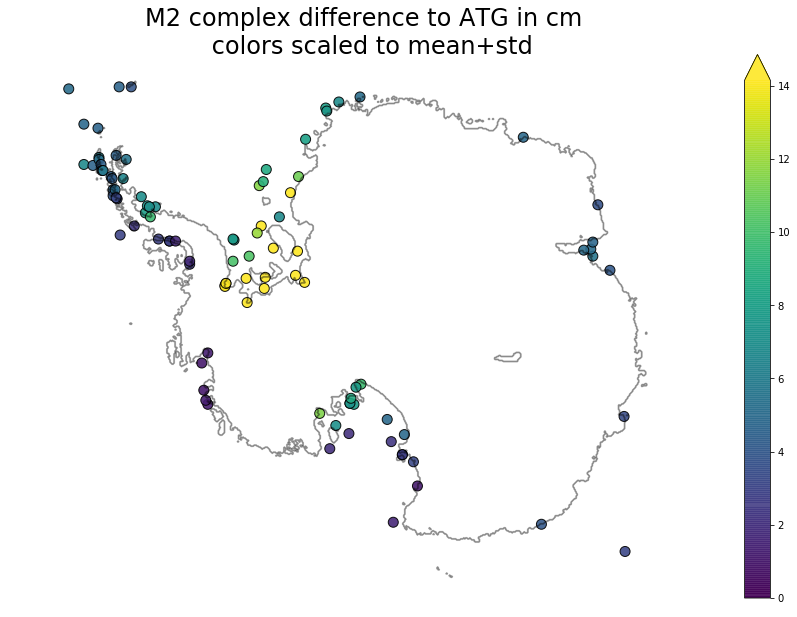

Excluded  25  stations


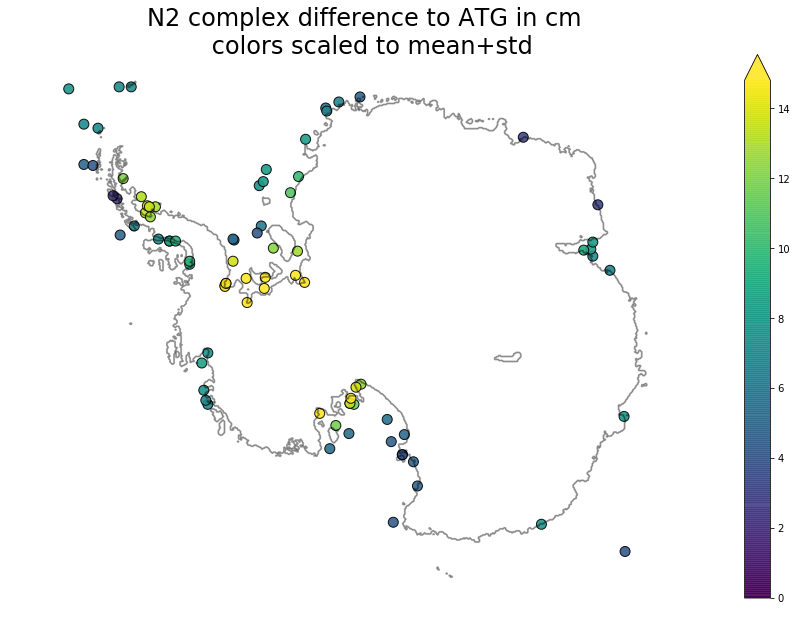

Excluded  12  stations


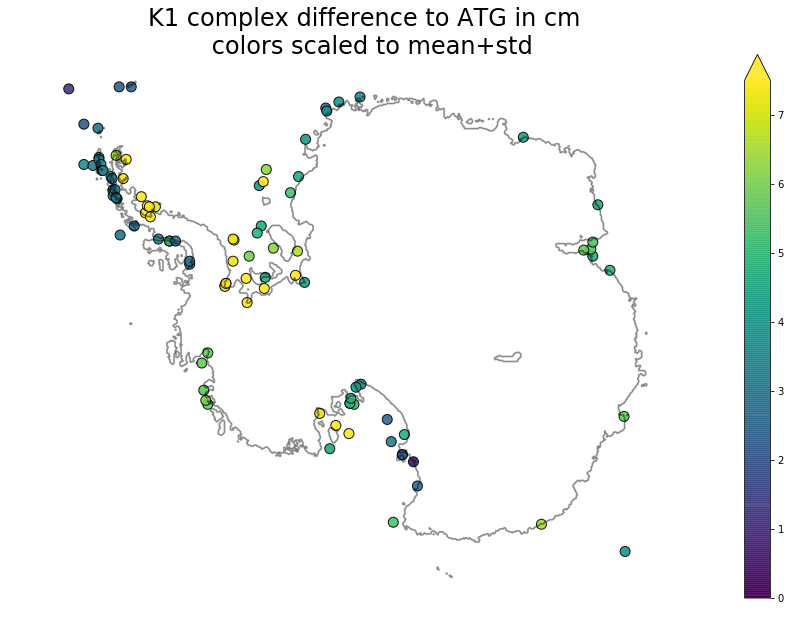

Excluded  11  stations


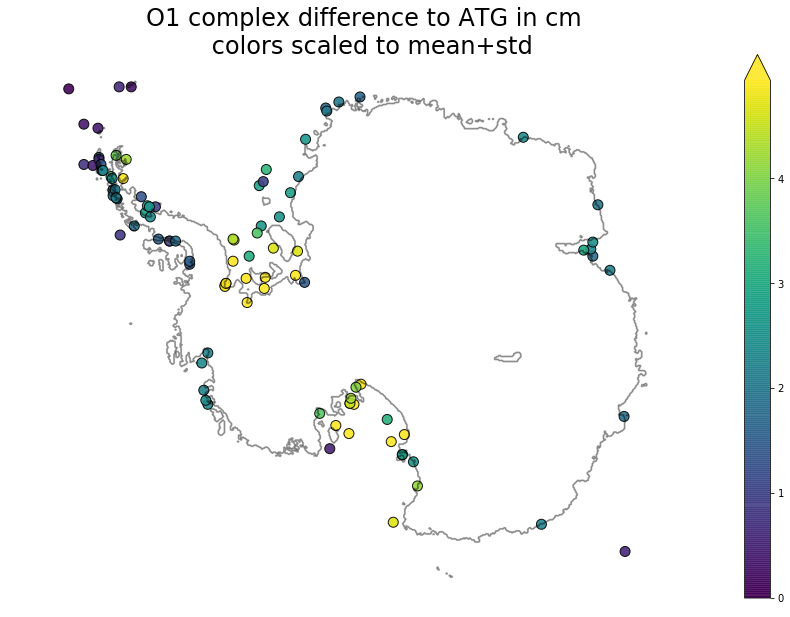

In [98]:
for constit in ["M2","N2","K1","O1"]:
    plot_zdiff_map(staions,grid,constit)